In [1]:
import os, math, numpy as np, pandas as pd
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from pandas import read_csv
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import MessagePassing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
import networkx as nx

In [2]:

EDGE_COLS = [
    'Bwd Packet Length Min', 'Protocol_6', 'Bwd Packets/s', 'FWD Init Win Bytes',
    'Packet Length Std', 'FIN Flag Count', 'SrcPortRange_registered',
    'Packet Length Min', 'Fwd Seg Size Min', 'DstPortRange_well_known',
    'Bwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Std'
]
ID_COLS = ['Src IP','Dst IP','Timestamp']
LABEL_COL = 'target'

In [3]:
# def time_posenc(t, periods=(60, 300, 3600)):
#     # t: numpy array of epoch seconds
#     feats = []
#     for P in periods:
#         w = 2*math.pi/P
#         feats.append(np.sin(w*t))
#         feats.append(np.cos(w*t))
#     return np.stack(feats, axis=1)  # [N, 2*len(periods)]

def bin_time(df, bin_seconds=300):
    # Expect df['Timestamp'] as datetime or string; convert to seconds
    ts = pd.to_datetime(df['Timestamp'], errors='coerce', utc=True).astype('int64') // 10**9
    df = df.copy()
    df['_epoch'] = ts
    df['_bin'] = (ts // bin_seconds).astype(int)
    return df

In [4]:
import numpy as np
import pandas as pd
from scipy import sparse

def compute_node_centralities_fast2(
    df: pd.DataFrame,
    ip2idx: dict,
    src_col: str = "Src IP",
    dst_col: str = "Dst IP",
    use_betweenness: bool = False,     # set True if you have NetworKit
    betw_samples: int = 32,            # NetworKit ApproxBetweenness samples
    pagerank_alpha: float = 0.85,
    pagerank_iters: int = 40,
    pagerank_tol: float = 1e-6,
    closeness_if_small: int = 20_000,  # only compute closeness if N <= this
    ktruss_if_small: int = 10_000      # only compute k-truss if N <= this
) -> np.ndarray:
    """
    Returns C: [N_nodes, 5] -> [degree, betweenness, closeness, pagerank, ktruss_level], z-scored per column.
    Fast path fills unavailable metrics with 0 (safe after z-scoring).
    """
    N = len(ip2idx)
    if N == 0:
        return np.zeros((0,5), dtype=float)

    # ------- Build sparse adjacency (directed) fast -------
    # Map to indices without Python loops
    src_idx = df[src_col].astype(str).map(ip2idx).to_numpy()
    dst_idx = df[dst_col].astype(str).map(ip2idx).to_numpy()
    mask = np.isfinite(src_idx) & np.isfinite(dst_idx)
    src_idx = src_idx[mask].astype(np.int64, copy=False)
    dst_idx = dst_idx[mask].astype(np.int64, copy=False)

    # Remove self-loops once (optional)
    non_self = src_idx != dst_idx
    src_idx, dst_idx = src_idx[non_self], dst_idx[non_self]

    data = np.ones_like(src_idx, dtype=np.float64)
    A = sparse.coo_matrix((data, (src_idx, dst_idx)), shape=(N, N)).tocsr()

    # ------- Degree (total degree for directed) -------
    outdeg = A.getnnz(axis=1)          # rows
    indeg  = A.getnnz(axis=0)          # cols
    degree = (outdeg + indeg).astype(np.float64)

    # ------- PageRank (power iteration on sparse) -------
    # Row-normalize A^T equivalent: P^T @ pr
    outdeg_safe = np.maximum(outdeg, 1)
    Dinv = sparse.diags(1.0 / outdeg_safe)
    P = Dinv @ A                       # row-stochastic (on rows)
    pr = np.full(N, 1.0 / N, dtype=np.float64)
    teleport = (1.0 - pagerank_alpha) / N
    for _ in range(pagerank_iters):
        pr_new = pagerank_alpha * (P.T @ pr) + teleport
        if np.linalg.norm(pr_new - pr, 1) < pagerank_tol:
            pr = pr_new
            break
        pr = pr_new

    # ------- Betweenness (optional, NetworKit) -------
    betw = np.zeros(N, dtype=np.float64)
    if use_betweenness:
        try:
            import networkit as nk
            # Build NetworKit graph
            Gnk = nk.Graph(n=N, weighted=False, directed=True)
            # Add edges (NetworKit expects int indices)
            # Faster add: iterate CSR rows
            rows, cols = A.nonzero()
            for u, v in zip(rows.tolist(), cols.tolist()):
                if u != v:
                    Gnk.addEdge(u, v)
            c = nk.centrality.ApproxBetweenness(Gnk, nSamples=int(betw_samples), normalized=True)
            c.run()
            betw = np.array(c.scores(), dtype=np.float64)
        except Exception:
            # If NetworKit not available, keep zeros (safe after z-score)
            pass

    # ------- Closeness (tiny graphs only, else zeros) -------
    clos = np.zeros(N, dtype=np.float64)
    if N <= closeness_if_small:
        try:
            import networkx as nx
            H = nx.from_scipy_sparse_array(A, create_using=nx.DiGraph)
            # Use NX fast approximation? (still Python; okay for small N)
            clos_dict = nx.closeness_centrality(H)  # directed-version
            # Map dict to array by index order
            # NetworkX labels are 0..N-1 when built from scipy sparse
            clos = np.array([clos_dict.get(i, 0.0) for i in range(N)], dtype=np.float64)
        except Exception:
            pass

    # ------- k-truss (tiny graphs only, else zeros) -------
    ktr = np.zeros(N, dtype=np.float64)
    if N <= ktruss_if_small:
        try:
            import networkx as nx
            Hu = nx.from_scipy_sparse_array((A + A.T).sign(), create_using=nx.Graph)
            ktr_level = np.zeros(N, dtype=np.int32)
            for k in range(3, 7):  # modest bound; raise carefully
                try:
                    Tk = nx.k_truss(Hu, k)
                except nx.NetworkXError:
                    break
                nodes = list(Tk.nodes())
                if not nodes:
                    continue
                ktr_level[np.array(nodes, dtype=np.int64)] = np.maximum(ktr_level[np.array(nodes, dtype=np.int64)], k)
            ktr = ktr_level.astype(np.float64)
        except Exception:
            pass

    # ------- Pack in the right slot order: [degree, betweenness, closeness, pagerank, ktruss] -------
    C = np.column_stack([degree, betw, clos, pr, ktr])

    # ------- z-score per column (robust to zeros) -------
    mu = C.mean(axis=0, keepdims=True)
    sd = C.std(axis=0, keepdims=True) + 1e-8
    C = (C - mu) / sd
    return C


In [5]:
# Fast unique IP mapping (string-safe)
def make_ip_index(df, src_col='Src IP', dst_col='Dst IP'):
    # Combine columns as one numpy array without concat copies
    src = df[src_col].astype(str).to_numpy(copy=False)
    dst = df[dst_col].astype(str).to_numpy(copy=False)
    all_ips = np.concatenate((src, dst))

    # Use pandas categorical (internally fast hash-based unique)
    cat = pd.Categorical(all_ips)
    ip2idx = dict(zip(cat.categories, range(len(cat.categories))))
    n_nodes = len(ip2idx)
    return ip2idx, n_nodes

def build_snapshots(df, scaler_edge=None, fit_scaler=False, bin_seconds=300, device='cpu', include_per_bin_feats=True):
    """
    Returns:
      snapshots: list[Data] in time order
      ip2idx: dict mapping IP -> node index (per full dataset, stable across train/test)
      scaler_edge: fitted StandardScaler for edge features
      edge_cols_kept: list of columns used (existing + non-NA + time enc + centralities names)
    """
    # Keep only available columns
    edge_cols = [c for c in EDGE_COLS if c in df.columns]
    cols_needed = ID_COLS + edge_cols + [LABEL_COL]
    cols_needed = [c for c in cols_needed if c in df.columns]
    df = df[cols_needed].dropna(subset=['Src IP','Dst IP'])
    df = bin_time(df, bin_seconds=bin_seconds)

    edge_cols = [c for c in EDGE_COLS if c in df.columns]
    for c in edge_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df[edge_cols] = df[edge_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # Edge feature scaler
    if scaler_edge is None:
        scaler_edge = StandardScaler()
        fit_scaler = True
    if fit_scaler and len(edge_cols) > 0:
        scaler_edge.fit(df[edge_cols].astype(float).values)

    ip2idx, n_nodes = make_ip_index(df)

    # --- NEW: centralities over the full graph ---
    C = compute_node_centralities_fast2( df, ip2idx,use_betweenness=False,     betw_samples=32,       pagerank_iters=40)

    snapshots = []
    prev_activity = defaultdict(int)  # lag-1 activity per node

    # iterate bins
    for b, g in df.sort_values('_bin').groupby('_bin'):
        # Map nodes
        src = g['Src IP'].map(ip2idx).astype(int).values
        dst = g['Dst IP'].map(ip2idx).astype(int).values
        edge_index = torch.tensor(np.vstack([src, dst]), dtype=torch.long)

        # Edge attributes = scaled flow features + time encoding
        if len(edge_cols) > 0:
            eX = scaler_edge.transform(g[edge_cols].astype(float).values)
        else:
            eX = np.empty((len(g), 0), dtype=float)
        # tfe = time_posenc(g['_epoch'].values)  # [E, 2*len(periods)]
        # edge_attr_np = np.hstack([eX, tfe])
        edge_attr_np = np.hstack([eX])
        edge_attr = torch.tensor(edge_attr_np, dtype=torch.float)
        edge_attr = torch.nan_to_num(edge_attr, nan=0.0, posinf=1e6, neginf=-1e6)

        # Labels (edge-level)
        y = torch.tensor(g[LABEL_COL].astype(int).values, dtype=torch.long)

        # Node features:
        #   (paper) centralities C; (yours) optional per-bin degrees + prev_activity
        if include_per_bin_feats:
            out_deg = np.bincount(src, minlength=n_nodes)
            in_deg  = np.bincount(dst, minlength=n_nodes)
            deg     = (out_deg + in_deg).reshape(-1,1)
            node_feat = np.hstack([
                in_deg.reshape(-1,1),
                out_deg.reshape(-1,1),
                deg,
                np.array([prev_activity[i] for i in range(n_nodes)]).reshape(-1,1)
            ])
            node_feat = np.log1p(node_feat)
            x_np = np.hstack([node_feat, C])  # [N, 4 + 5]
        else:
            x_np = C  # strict paper-style init

        x = torch.tensor(x_np, dtype=torch.float)
        x = torch.nan_to_num(x, nan=0.0, posinf=1e6, neginf=-1e6)

        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y
        )
        data._bin = int(b)
        snapshots.append(data)

        # Update prev_activity for next bin (count edges touched by node this bin)
        touched = np.bincount(np.concatenate([src, dst]), minlength=n_nodes)
        for i, c in enumerate(touched):
            prev_activity[i] = int(c)

    # Column names returned (only for info)
    # time_cols = [f'time_{i}' for i in range(tfe.shape[1])]
    # cent_cols = ['cent_degree','cent_betweenness','cent_closeness','cent_pagerank','cent_ktruss']
    # edge_cols_used = edge_cols + time_cols + cent_cols

    # time_cols = [f'time_{i}' for i in range(tfe.shape[1])]
    cent_cols = ['cent_degree','cent_betweenness','cent_closeness','cent_pagerank','cent_ktruss']
    edge_cols_used = edge_cols + cent_cols
    return snapshots, ip2idx, scaler_edge, edge_cols_used

In [6]:
class EdgeGraphSAGEConv(MessagePassing):
    """
    Edge-aware GraphSAGE (E-GraphSAGE-like):
      m_ij = gate([x_i, x_j, e_ij]) * φ( Wj x_j + Wi x_i + We e_ij )
      h_i' = Norm( mean_j m_ij + Wself x_i )     (residual)
    """
    def __init__(self, in_channels: int, edge_in: int, out_channels: int, aggr: str = "mean", dropout: float = 0.0):
        super().__init__(aggr=aggr, node_dim=0)
        self.lin_src  = nn.Linear(in_channels, out_channels, bias=False)
        self.lin_dst  = nn.Linear(in_channels, out_channels, bias=False)
        self.lin_edge = nn.Linear(edge_in,    out_channels, bias=False)
        self.lin_self = nn.Linear(in_channels, out_channels, bias=True)

        # Small gate that decides how much of each message passes through
        self.gate = nn.Sequential(
            nn.Linear(in_channels + in_channels + edge_in, out_channels // 2),
            nn.ReLU(),
            nn.Linear(out_channels // 2, 1)
        )

        self.norm = nn.LayerNorm(out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)  # -> [N, Fout]
        out = out + self.lin_self(x)  # residual
        out = self.norm(out)
        return out

    def message(self, x_i: torch.Tensor, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        msg_raw = self.lin_src(x_j) + self.lin_dst(x_i) + self.lin_edge(edge_attr)
        g = torch.sigmoid(self.gate(torch.cat([x_i, x_j, edge_attr], dim=-1)))
        msg = F.relu(msg_raw) * g
        return self.dropout(msg)

    def update(self, aggr_out: torch.Tensor) -> torch.Tensor:
        return aggr_out

In [23]:
class GraphTimeEdgeClassifier(nn.Module):
    """
    E-GraphSAGE-style backbone that uses edge attributes inside message passing
    AND in the final edge-level head.
    """
    def __init__(self, in_node: int, in_edge: int, hidden: int = 100, num_layers: int = 2, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        layers = []
        dims = [in_node] + [hidden] * num_layers
        for i in range(num_layers):
            layers.append(EdgeGraphSAGEConv(dims[i], in_edge, dims[i+1], aggr="mean", dropout=dropout))
        self.convs = nn.ModuleList(layers)

        # Edge MLP head: combine node embeddings and edge features
        edge_head_in = (2 * hidden) + in_edge + hidden + hidden  # [h_s, h_d, e, |h_s-h_d|, h_s*h_d]
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_head_in, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2)
        )

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        for conv in self.convs:
            x = conv(x, edge_index, edge_attr)
            x = F.relu(x)
            x = self.dropout(x)

        src, dst = edge_index
        h_s, h_d = x[src], x[dst]
        h_abs = torch.abs(h_s - h_d)
        h_mul = h_s * h_d
        z = torch.cat([h_s, h_d, edge_attr, h_abs, h_mul], dim=-1)

        logits = self.edge_mlp(z)
        return logits

In [8]:
def run_epoch_neighbor(model, snapshot: Data, optimizer=None, device='cuda',
                       num_neighbors=[25,10], batch_size=4096, shuffle=True):
    is_train = optimizer is not None
    ce = nn.CrossEntropyLoss()
    total_loss, total_correct, total_edges = 0.0, 0, 0
    all_preds, all_trues = [], []

    model.train() if is_train else model.eval()

    loader = NeighborLoader(snapshot, num_neighbors=num_neighbors, batch_size=batch_size, shuffle=shuffle)
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)

        if is_train:
            loss = ce(logits, batch.y)
            if not torch.isfinite(loss):
                # skip this minibatch if something went bad
                continue
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += float(loss.item()) * batch.y.numel()

        with torch.no_grad():
            pred = logits.argmax(dim=1)
            all_preds.append(pred.cpu().numpy())
            all_trues.append(batch.y.cpu().numpy())
            total_correct += int((pred == batch.y).sum())
            total_edges += int(batch.y.numel())

    # Metrics
    if all_trues:
        y_true = np.concatenate(all_trues)
        y_pred = np.concatenate(all_preds)
        weighted_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0,0,0,0)
        fpr = fp / max(1, (fp + tn))
    else:
        weighted_f1, fpr = float('nan'), float('nan')

    avg_loss = (total_loss / max(1, total_edges)) if is_train else None
    acc = total_correct / max(1, total_edges)
    return avg_loss, acc, weighted_f1, fpr

In [9]:
train_df = pd.read_csv('train.csv')


In [10]:
test_df = pd.read_csv('test_new.csv')

In [11]:
import numpy as np
import pandas as pd

def optimize_numeric_dtypes(df: pd.DataFrame, try_float16: bool = False, verbose: bool = True) -> pd.DataFrame:
    """
    Downcast numeric columns to the smallest possible dtype without changing values.
    - Integers: downcast to smallest signed/unsigned integer.
    - Floats: downcast to float32 (and optionally float16 if lossless within tolerance).
    Returns a new DataFrame (original unchanged).
    """
    result = df.copy()
    start_mem = result.memory_usage(deep=True).sum() / 1024**2

    num_cols = [c for c in result.columns if pd.api.types.is_numeric_dtype(result[c])]
    for c in num_cols:
        col = result[c]

        # Skip all-NaN
        if col.notnull().sum() == 0:
            continue

        if pd.api.types.is_integer_dtype(col):
            # Integer (no NaNs)
            if col.min() >= 0:
                result[c] = pd.to_numeric(col, downcast="unsigned")
            else:
                result[c] = pd.to_numeric(col, downcast="integer")

        elif pd.api.types.is_float_dtype(col):
            # First, try float32
            col32 = col.astype(np.float32)
            if np.allclose(col.values, col32.values, equal_nan=True):
                result[c] = col32
                # Optionally try float16 (more aggressive)
                if try_float16:
                    col16 = col.astype(np.float16)
                    if np.allclose(col.values, col16.astype(np.float32).values, rtol=1e-03, atol=1e-06, equal_nan=True):
                        result[c] = col16
            # else keep original float64

        # If it's a nullable integer (Int64/Int32), try to preserve nulls with the smallest nullable int
        elif pd.api.types.is_dtype_equal(col.dtype, "Int64") or str(col.dtype).startswith("Int"):
            if col.min() >= 0:
                tmp = pd.to_numeric(col.astype("float64"), downcast="unsigned")
            else:
                tmp = pd.to_numeric(col.astype("float64"), downcast="integer")
            # Cast back to nullable integer if still integer-like
            if pd.api.types.is_integer_dtype(tmp):
                result[c] = pd.Series(tmp, index=col.index).astype(pd.ArrowDtype(tmp.dtype.name) if hasattr(pd, "ArrowDtype") else tmp.dtype)

    end_mem = result.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f"Memory: {start_mem:.2f} MB → {end_mem:.2f} MB ({(start_mem-end_mem):.2f} MB saved, {(1 - end_mem/max(start_mem,1e-9))*100:.1f}% reduction)")

    return result

# --- Example ---
# df_optimized = optimize_numeric_dtypes(df, try_float16=False, verbose=True)


In [12]:
train_df_small = optimize_numeric_dtypes(train_df.copy(), True, True)
test_df_small = optimize_numeric_dtypes(test_df.copy(), True, True)



C:\Users\Alice\PycharmProjects\co-simulation-code\.venv1\Lib\site-packages\pandas\core\dtypes\astype.py:170: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


Memory: 7706.79 MB → 6101.18 MB (1605.61 MB saved, 20.8% reduction)


C:\Users\Alice\PycharmProjects\co-simulation-code\.venv1\Lib\site-packages\pandas\core\dtypes\astype.py:170: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


Memory: 3830.07 MB → 3032.72 MB (797.35 MB saved, 20.8% reduction)


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
device

'cuda'

In [15]:
# Build train snapshots (fit scaler)
train_snaps, train_ip2idx, scaler_edge, edge_cols_used = build_snapshots(
    train_df_small, scaler_edge=None, fit_scaler=True, bin_seconds=300, device=device, include_per_bin_feats=False
)

# Build test snapshots (reuse scaler; separate ip2idx for strict inductive)
test_snaps, test_ip2idx, _, _ = build_snapshots(
    test_df_small, scaler_edge=scaler_edge, fit_scaler=False, bin_seconds=300, device=device, include_per_bin_feats=False
)

In [22]:
in_node = train_snaps[0].x.size(1)         # now includes centralities (+ optional per-bin feats)
in_edge = train_snaps[0].edge_attr.size(1) # edge features + time enc
model = GraphTimeEdgeClassifier(in_node=in_node, in_edge=in_edge,
                                hidden=100, num_layers=2, dropout=0.2).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [24]:
import torch, os, copy, json
ckpt_path = "best_f1.pt"   # change if you like

best_f1 = -1.0
best_epoch = None
best_state = None

EPOCHS = 10
batch_size = 4096*128

for epoch in range(1, EPOCHS+1):
    tr_losses, tr_accs, tr_f1s, tr_fprs = [], [], [], []
    for snap in train_snaps:
        tr_loss, tr_acc, tr_f1, tr_fpr = run_epoch_neighbor(
            model, snap, optimizer=opt, device=device,
            num_neighbors=[25,10], batch_size=batch_size, shuffle=True
        )
        tr_losses.append(tr_loss if tr_loss is not None else 0.0)
        tr_accs.append(tr_acc); tr_f1s.append(tr_f1); tr_fprs.append(tr_fpr)

    # Eval on test with neighbor sampling (no optimizer)
    te_accs, te_f1s, te_fprs = [], [], []
    for snap in test_snaps:
        _, te_acc, te_f1, te_fpr = run_epoch_neighbor(
            model, snap, optimizer=None, device=device,
            num_neighbors=[25,10], batch_size=batch_size, shuffle=False
        )
        te_accs.append(te_acc); te_f1s.append(te_f1); te_fprs.append(te_fpr)

    mean_tr_loss = float(np.mean(tr_losses))
    mean_tr_acc  = float(np.mean(tr_accs))
    mean_tr_f1   = float(np.mean(tr_f1s))
    mean_tr_fpr  = float(np.mean(tr_fprs))

    mean_te_acc  = float(np.mean(te_accs))
    mean_te_f1   = float(np.mean(te_f1s))
    mean_te_fpr  = float(np.mean(te_fprs))

    print(f"Epoch {epoch:02d} | "
          f"train loss {mean_tr_loss:.4f} | train acc {mean_tr_acc:.4f} | "
          f"train F1 {mean_tr_f1:.4f} | train FPR {mean_tr_fpr:.4f} | "
          f"test acc {mean_te_acc:.4f} | test F1 {mean_te_f1:.4f} | test FPR {mean_te_fpr:.4f}")

    # ---- save best by TEST F1 ----
    if mean_te_f1 > best_f1:
        best_f1 = mean_te_f1
        best_epoch = epoch
        best_state = {
            "model_state": copy.deepcopy(model.state_dict()),
            "epoch": best_epoch,
            "best_test_f1": best_f1,
        }
        torch.save(best_state, ckpt_path)
        print(f"✅ Saved new best model @ epoch {epoch} (test F1={best_f1:.4f}) → {ckpt_path}")


Epoch 01 | train loss 0.0032 | train acc 0.9993 | train F1 0.9994 | train FPR 0.0006 | test acc 0.9993 | test F1 0.9990 | test FPR 0.0000
✅ Saved new best model @ epoch 1 (test F1=0.9990) → best_f1.pt
Epoch 02 | train loss 0.0013 | train acc 0.9993 | train F1 0.9995 | train FPR 0.0006 | test acc 0.9988 | test F1 0.9987 | test FPR 0.0005
Epoch 03 | train loss 0.0010 | train acc 0.9999 | train F1 0.9998 | train FPR 0.0000 | test acc 0.9988 | test F1 0.9987 | test FPR 0.0006
Epoch 04 | train loss 0.0003 | train acc 0.9999 | train F1 0.9999 | train FPR 0.0000 | test acc 0.9988 | test F1 0.9987 | test FPR 0.0005
Epoch 05 | train loss 0.0002 | train acc 0.9999 | train F1 0.9999 | train FPR 0.0000 | test acc 0.9988 | test F1 0.9987 | test FPR 0.0006
Epoch 06 | train loss 0.0001 | train acc 1.0000 | train F1 1.0000 | train FPR 0.0000 | test acc 0.9988 | test F1 0.9987 | test FPR 0.0006
Epoch 07 | train loss 0.0006 | train acc 1.0000 | train F1 0.9999 | train FPR 0.0000 | test acc 0.9988 | test

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_with_confusion(model, snapshots, device='cpu'):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for data in snapshots:
            data = data.to(device)
            logits = model(data)
            preds = logits.argmax(dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    print("📊 Classification Report:")
    print(report)

    return cm, report

Evaluation

C:\Users\Alice\AppData\Local\Temp\ipykernel_8980\3316944521.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


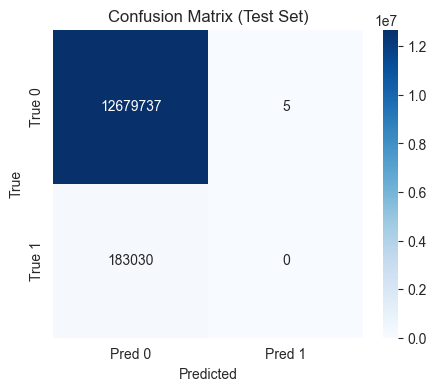

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9858    1.0000    0.9928  12679742
           1     0.0000    0.0000    0.0000    183030

    accuracy                         0.9858  12862772
   macro avg     0.4929    0.5000    0.4964  12862772
weighted avg     0.9717    0.9858    0.9787  12862772



In [19]:
ckpt_path = "best_f1.pt"  # same path you saved to

state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["model_state"])
model.to(device).eval()   # ensure eval mode + on the right device

cm, report = evaluate_with_confusion(model, test_snaps, device=device)


Error analysis, trying to see which IP adresses failed

C:\Users\Alice\AppData\Local\Temp\ipykernel_25252\3316944521.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)
C:\Users\

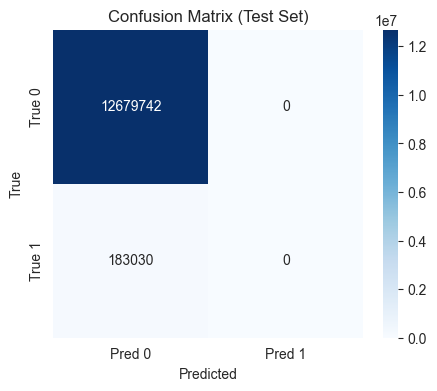

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9858    1.0000    0.9928  12679742
           1     0.0000    0.0000    0.0000    183030

    accuracy                         0.9858  12862772
   macro avg     0.4929    0.5000    0.4964  12862772
weighted avg     0.9717    0.9858    0.9787  12862772



In [25]:
ckpt_path = "best_f1.pt"  # same path you saved to

state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["model_state"])
model.to(device).eval()   # ensure eval mode + on the right device

cm, report = evaluate_with_confusion(model, test_snaps, device=device)


In [20]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

def collect_edge_predictions(model, snapshots, ip_idx_to_ip=None, device='cpu',
                             keep_edge_cols=False):
    """
    Returns a DataFrame with one row per edge prediction:
    columns: ['bin','src_idx','dst_idx','src_ip','dst_ip','y_true','y_pred','p1','margin','loss_ce']
    """
    rows = []
    ce = torch.nn.CrossEntropyLoss(reduction='none')
    model.eval()
    with torch.no_grad():
        for data in snapshots:
            d = data.to(device)
            logits = model(d)                         # [E,2]
            probs  = F.softmax(logits, dim=1)[:,1]   # p(y=1)
            y_true = d.y
            y_pred = (probs >= 0.5).long()
            per_ce = ce(logits, y_true)              # per-edge CE loss

            # Map edge indices back to nodes
            src, dst = d.edge_index
            src = src.cpu().numpy()
            dst = dst.cpu().numpy()

            # Optional: map to IP strings if provided
            if ip_idx_to_ip is not None:
                src_ip = [ip_idx_to_ip.get(int(i), str(int(i))) for i in src]
                dst_ip = [ip_idx_to_ip.get(int(i), str(int(i))) for i in dst]
            else:
                src_ip = [int(i) for i in src]
                dst_ip = [int(i) for i in dst]

            # Prediction stats
            probs_np  = probs.cpu().numpy()
            logits_np = logits.cpu().numpy()
            margin_np = (logits_np[:,1] - logits_np[:,0])  # logit margin
            y_true_np = y_true.cpu().numpy()
            y_pred_np = y_pred.cpu().numpy()
            loss_np   = per_ce.cpu().numpy()

            for i in range(len(y_true_np)):
                rows.append({
                    'bin': getattr(data, '_bin', -1),
                    'src_idx': int(src[i]),
                    'dst_idx': int(dst[i]),
                    'src_ip': src_ip[i],
                    'dst_ip': dst_ip[i],
                    'y_true': int(y_true_np[i]),
                    'y_pred': int(y_pred_np[i]),
                    'p1': float(probs_np[i]),
                    'margin': float(margin_np[i]),
                    'loss_ce': float(loss_np[i]),
                })
    df_pred = pd.DataFrame(rows).sort_values(['bin','loss_ce'], ascending=[True, False])
    return df_pred


In [21]:
def bin_metrics(df_pred):
    out = []
    for b, g in df_pred.groupby('bin'):
        y, yhat = g['y_true'].values, g['y_pred'].values
        p1 = g['p1'].values
        tp = ((y==1)&(yhat==1)).sum()
        fp = ((y==0)&(yhat==1)).sum()
        tn = ((y==0)&(yhat==0)).sum()
        fn = ((y==1)&(yhat==0)).sum()
        acc = (tp+tn)/max(1,len(g))
        prec = tp/max(1,tp+fp)
        rec  = tp/max(1,tp+fn)
        f1   = 2*prec*rec/max(1e-9,prec+rec)
        try:
            auc = roc_auc_score(y, p1) if (y.min()!=y.max()) else np.nan
        except Exception:
            auc = np.nan
        out.append({'bin': b, 'n': len(g), 'acc':acc, 'precision':prec,
                    'recall':rec, 'f1':f1, 'auc':auc, 'fp':fp, 'fn':fn})
    return pd.DataFrame(out).sort_values('bin')


In [22]:
def top_false_negatives(df_pred, k=20):
    return df_pred[(df_pred.y_true==1)&(df_pred.y_pred==0)].sort_values('margin').head(k)

def top_false_positives(df_pred, k=20):
    return df_pred[(df_pred.y_true==0)&(df_pred.y_pred==1)].sort_values('p1', ascending=False).head(k)


In [23]:
def offender_table(df_pred, by='src_ip', k=30):
    g = df_pred.groupby(by).apply(
        lambda t: pd.Series({
            'n': len(t),
            'fn': int(((t.y_true==1)&(t.y_pred==0)).sum()),
            'fp': int(((t.y_true==0)&(t.y_pred==1)).sum()),
            'err_rate': float((t.y_true!=t.y_pred).mean())
        })
    ).reset_index()
    g['fn_share'] = g['fn']/g['n'].clip(lower=1)
    g['fp_share'] = g['fp']/g['n'].clip(lower=1)
    return g.sort_values(['err_rate','n'], ascending=[False,False]).head(k)


In [24]:
from sklearn.metrics import precision_recall_curve

def tune_threshold(df_pred, fn_cost=5.0, fp_cost=1.0):
    """
    Choose threshold that minimizes cost = fn_cost*FN + fp_cost*FP.
    """
    y = df_pred['y_true'].values
    p = df_pred['p1'].values
    # Sweep thresholds via precision-recall curve
    prec, rec, thr = precision_recall_curve(y, p)
    # Convert to FPs/FNs given counts
    P = (y==1).sum()
    N = (y==0).sum()
    # recall = TP/P -> TP = recall*P
    # precision = TP/(TP+FP) -> FP = TP*(1/precision - 1)
    TP = rec * P
    FP = TP * (1/np.clip(prec,1e-9,None) - 1)
    FN = P - TP
    cost = fn_cost*FN + fp_cost*FP
    idx = np.nanargmin(cost)
    best_thr = thr[idx-1] if idx>0 and idx-1 < len(thr) else 0.5
    stats = {'best_thr': float(best_thr), 'cost': float(cost[idx]),
             'recall': float(rec[idx]), 'precision': float(prec[idx])}
    return best_thr, stats


In [25]:
def error_by_feature_quantiles(df_joined, feature, q=10):
    """
    df_joined: df_pred merged with raw edge features for the same edge rows
               must contain columns: feature, y_true, y_pred
    """
    cuts = pd.qcut(df_joined[feature], q=q, duplicates='drop')
    g = df_joined.groupby(cuts).apply(lambda t: pd.Series({
        'n': len(t),
        'err_rate': float((t.y_true!=t.y_pred).mean()),
        'fn_rate': float(((t.y_true==1)&(t.y_pred==0)).mean()),
        'fp_rate': float(((t.y_true==0)&(t.y_pred==1)).mean()),
        'avg_p1': float(t['p1'].mean())
    })).reset_index().rename(columns={feature:'bin_'+feature})
    return g.sort_values('err_rate', ascending=False)


In [26]:
# After each test epoch:
idx2ip_train = {v:k for k,v in train_ip2idx.items()}
idx2ip_test  = {v:k for k,v in test_ip2idx.items()}

df_train_pred = collect_edge_predictions(model, train_snaps, idx2ip_train, device=device)
df_test_pred  = collect_edge_predictions(model, test_snaps,  idx2ip_test,  device=device)

print("\n=== Per-bin (TEST) ===")
print(bin_metrics(df_test_pred).to_string(index=False))

print("\n=== Top FN (TEST) ===")
print(top_false_negatives(df_test_pred, k=15)[['bin','src_ip','dst_ip','p1','margin','loss_ce']].to_string(index=False))

print("\n=== Top FP (TEST) ===")
print(top_false_positives(df_test_pred, k=15)[['bin','src_ip','dst_ip','p1','margin','loss_ce']].to_string(index=False))

print("\n=== Offenders by src_ip (TEST) ===")
print(offender_table(df_test_pred, by='src_ip', k=20).to_string(index=False))

# Threshold tuning globally (you can also do this per bin)
best_thr, stats = tune_threshold(df_train_pred, fn_cost=5.0, fp_cost=1.0)
print(f"\n[Threshold] best {best_thr:.3f} | recall={stats['recall']:.3f} precision={stats['precision']:.3f}")



=== Per-bin (TEST) ===
    bin     n      acc  precision  recall  f1      auc  fp   fn
5066355 69015 1.000000        0.0     0.0 0.0      NaN   0    0
5066356 65243 1.000000        0.0     0.0 0.0      NaN   0    0
5066357 72318 1.000000        0.0     0.0 0.0      NaN   0    0
5066358 56812 1.000000        0.0     0.0 0.0      NaN   0    0
5066359 53291 1.000000        0.0     0.0 0.0      NaN   0    0
5066360 56213 1.000000        0.0     0.0 0.0      NaN   0    0
5066361 58177 1.000000        0.0     0.0 0.0      NaN   0    0
5066362 63135 1.000000        0.0     0.0 0.0      NaN   0    0
5066363 58675 0.999949        0.0     0.0 0.0      NaN   3    0
5066364 58612 1.000000        0.0     0.0 0.0      NaN   0    0
5066365 49598 1.000000        0.0     0.0 0.0      NaN   0    0
5066366 57352 1.000000        0.0     0.0 0.0      NaN   0    0
5066367 65861 1.000000        0.0     0.0 0.0      NaN   0    0
5066368 57852 1.000000        0.0     0.0 0.0      NaN   0    0
5066369 58785 1.

Here, we will see which IPs repeat in both training and test set.

In [27]:
import pandas as pd
import numpy as np

SRC = 'Src IP'
DST = 'Dst IP'

def ip_overlap_report(train_df: pd.DataFrame, test_df: pd.DataFrame,
                      src=SRC, dst=DST) -> pd.DataFrame:
    # counts per IP in each split (count both src and dst appearances)
    tr_counts = pd.concat([train_df[src].astype(str), train_df[dst].astype(str)]).value_counts()
    te_counts = pd.concat([test_df[src].astype(str),  test_df[dst].astype(str)]).value_counts()

    # align on the union of IPs
    all_ips = tr_counts.index.union(te_counts.index)
    df = pd.DataFrame({
        'train_count': tr_counts.reindex(all_ips, fill_value=0),
        'test_count' : te_counts.reindex(all_ips, fill_value=0),
    })
    df['in_train'] = df['train_count'] > 0
    df['in_test']  = df['test_count']  > 0
    df['status']   = np.where(df['in_train'] & df['in_test'], 'both',
                       np.where(df['in_train'], 'train_only', 'test_only'))
    return df.sort_values(['status','train_count','test_count'], ascending=[True, False, False])

def edge_overlap_counts(train_df: pd.DataFrame, test_df: pd.DataFrame,
                        src=SRC, dst=DST):
    # sets of directed edges (src,dst) as strings
    tr_pairs = set(zip(train_df[src].astype(str), train_df[dst].astype(str)))
    te_pairs = set(zip(test_df[src].astype(str),  test_df[dst].astype(str)))

    both      = tr_pairs & te_pairs
    train_only= tr_pairs - te_pairs
    test_only = te_pairs - tr_pairs

    print(f'Edges — train unique: {len(tr_pairs):,}, test unique: {len(te_pairs):,}')
    print(f'Edges in both: {len(both):,} | only in train: {len(train_only):,} | only in test: {len(test_only):,}')
    return tr_pairs, te_pairs, both, train_only, test_only

# ---- run it ----
ip_df = ip_overlap_report(train_df, test_df)

print(f'Unique IPs — train: {ip_df.in_train.sum():,}, test: {ip_df.in_test.sum():,}')
print(f'IPs in both: {(ip_df.status=="both").sum():,} | only in train: {(ip_df.status=="train_only").sum():,} | only in test: {(ip_df.status=="test_only").sum():,}')

# peek at each group (top 10 by total count)
display(ip_df.query('status=="both"').assign(total=ip_df.train_count+ip_df.test_count).sort_values('total', ascending=False).head(10))
display(ip_df.query('status=="train_only"').sort_values('train_count', ascending=False).head(10))
display(ip_df.query('status=="test_only"').sort_values('test_count', ascending=False).head(10))

# save full lists if useful
ip_df.query('status=="both"').to_csv('ips_in_both.csv')
ip_df.query('status=="train_only"').to_csv('ips_train_only.csv')
ip_df.query('status=="test_only"').to_csv('ips_test_only.csv')

# (optional) do the same analysis for edges
_ = edge_overlap_counts(train_df, test_df)


Unique IPs — train: 94,905, test: 56,495
IPs in both: 21,737 | only in train: 73,168 | only in test: 34,758


,train_count,test_count,in_train,in_test,status,total
172.31.0.2,10080402,4519097,True,True,both,14599499
172.31.69.25,2491900,2641,True,True,both,2494541
169.254.169.254,1139718,529475,True,True,both,1669193
5.101.40.105,243174,220146,True,True,both,463320
5.101.40.43,178045,231647,True,True,both,409692
212.92.116.6,157039,80606,True,True,both,237645
72.21.91.29,158517,77350,True,True,both,235867
172.31.64.103,131615,66031,True,True,both,197646
172.31.64.83,122313,74454,True,True,both,196767
172.31.65.56,83593,57038,True,True,both,140631


,train_count,test_count,in_train,in_test,status
18.219.193.20,1803246,0,True,False,train_only
18.221.219.4,193354,0,True,False,train_only
175.195.219.31,118464,0,True,False,train_only
13.59.126.31,105550,0,True,False,train_only
212.92.114.68,104823,0,True,False,train_only
152.101.118.11,95057,0,True,False,train_only
13.58.98.64,94237,0,True,False,train_only
145.239.183.169,76780,0,True,False,train_only
77.243.191.23,75507,0,True,False,train_only
69.16.250.107,74297,0,True,False,train_only


,train_count,test_count,in_train,in_test,status
18.219.211.138,0,143183,False,True,test_only
212.92.107.25,0,72528,False,True,test_only
196.52.84.25,0,71803,False,True,test_only
87.230.72.8,0,60719,False,True,test_only
219.135.224.15,0,52834,False,True,test_only
165.132.169.106,0,46722,False,True,test_only
221.126.225.109,0,37988,False,True,test_only
212.92.124.11,0,37831,False,True,test_only
189.236.198.113,0,31938,False,True,test_only
80.241.219.91,0,31789,False,True,test_only


Edges — train unique: 1,164,890, test unique: 683,335
Edges in both: 211,652 | only in train: 953,238 | only in test: 471,683


In [28]:
import pandas as pd
import numpy as np

SRC, DST = 'Src IP', 'Dst IP'

def where_ips_live(train_df, test_df, ips=None, src=SRC, dst=DST):
    tr_src = train_df[src].astype(str)
    tr_dst = train_df[dst].astype(str)
    te_src = test_df[src].astype(str)
    te_dst = test_df[dst].astype(str)

    # counts per role
    tr_src_ct = tr_src.value_counts()
    tr_dst_ct = tr_dst.value_counts()
    te_src_ct = te_src.value_counts()
    te_dst_ct = te_dst.value_counts()

    # which IPs to check (all or a subset)
    if ips is None:
        ips = sorted(set(tr_src_ct.index) | set(tr_dst_ct.index) |
                     set(te_src_ct.index) | set(te_dst_ct.index))
    idx = pd.Index(map(str, ips), name='ip')

    out = pd.DataFrame(index=idx)
    out['train_src'] = out.index.map(tr_src_ct).fillna(0).astype(int)
    out['train_dst'] = out.index.map(tr_dst_ct).fillna(0).astype(int)
    out['test_src']  = out.index.map(te_src_ct).fillna(0).astype(int)
    out['test_dst']  = out.index.map(te_dst_ct).fillna(0).astype(int)

    out['train_total'] = out['train_src'] + out['train_dst']
    out['test_total']  = out['test_src']  + out['test_dst']
    out['in_train'] = out['train_total'] > 0
    out['in_test']  = out['test_total']  > 0
    out['status'] = np.select(
        [out.in_train & out.in_test, out.in_train, out.in_test],
        ['both','train_only','test_only'],
        default='neither'
    )
    # nice ordering
    return out.sort_values(['status','test_total','train_total'], ascending=[True, False, False])


In [29]:
offender_ips = [
    '172.31.69.13','172.31.69.30','172.31.69.8','172.31.69.17','172.31.69.10',
    '172.31.69.26','172.31.69.14','172.31.69.23','172.31.69.6','172.31.69.29', '172.31.69.12'
]
display(where_ips_live(train_df, test_df, offender_ips))


,train_src,train_dst,test_src,test_dst,train_total,test_total,in_train,in_test,status
ip,,,,,,,,,
172.31.69.13,52208,8466,66890,9720,60674,76610,True,True,both
172.31.69.29,46216,12401,31734,9642,58617,41376,True,True,both
172.31.69.6,49473,15378,31150,9827,64851,40977,True,True,both
172.31.69.23,52717,12109,30025,8307,64826,38332,True,True,both
172.31.69.10,51224,10631,29656,8492,61855,38148,True,True,both
172.31.69.30,47013,16957,28568,6955,63970,35523,True,True,both
172.31.69.26,49934,9974,28758,6528,59908,35286,True,True,both
172.31.69.14,44215,18067,29565,5419,62282,34984,True,True,both
172.31.69.17,45756,17078,28708,5978,62834,34686,True,True,both
